In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
from processAc_tomo_funcs import ShowMeWFs_MC as show_wfs
from processAc_tomo_funcs import getfullWFref, rms, amp, calcWFchunks, delay
from findidxs import *
from LoadAcFile import *

# import fnmatch
# import os

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot, row, column
output_notebook()

Loading BokehJS ...

Loading BokehJS ...

In [2]:
data = pd.read_csv('../p5384_mechdat_reduced.zip')

Time = data.T.to_numpy()[0,:]
# Sync = data.T.to_numpy()[2,:]
effNS = data.T.to_numpy()[11,:]
del data

In [3]:
# define settings
acousticrun = 'run2'; # select the acoustic run to analyze after adjusting indexes (from figure 1) and the path

# switch acousticrun  

#     case 'run1' 
               
AcSettingsfile = '/Volumes/DOE/p5483/p5483_run2.mat' # acoustic settings file (located in the current directory)
AcSyncFile = './p5483_sync_run2.npz'; # sync file 
WF_path = '/Volumes/DOE/p5483/run2/WF_'; # where the WFs are                                                 

# Portion of the WF to analyze
idx2analyze = np.zeros((8,11,2),dtype='int') # 1st dim => transmitters, 2nd dim => receivers, 3rd dim => beg and end

idx2analyze[0,:,:] = [[130, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T1
idx2analyze[1,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T2
idx2analyze[2,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T3
idx2analyze[3,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T4
idx2analyze[4,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T5
idx2analyze[5,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T6
idx2analyze[6,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T7
idx2analyze[7,:,:] = [[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337],[150, 337]] #T8

# Display waveforms sent by transmitter WhichTrans
WhichTrans = 1;           
# Time Range
TimeRange = np.array([]); # in seconds. Analyze acoustic data over that time range only. If empty, the whole run is analyzed
AtWhichTimes = np.array([16379, 17329, 18018])
NtoStack = 3
ref_type = 'absref'; #'absref', 'relref' or 'mixref';

In [4]:
Filter = 0; #1 to filter, 0 not to filter
Filter_freq = np.array([0.25, 2]) #pass band filter 0.25MHz 2MHz
Filter_order = 256;
Filter_view = 1;

displayoptions = 1; # choose 0 to display all waveforms or 1 to display one set of waveforms over 100

ref_NrefWF = 50;

# offset waveforms by Offset when multiple channels are used
Offset1 = 10000;
Offset2 = 10000;

# used for 'relref' or 'mixref'
threshold = 0.95;

FreqQ = 400e3; # frequency at which the amplitude is monitored
NZPad = 2048; #2^18; 2048 number of samples for zero padding before fft 


# GEOMETRY
# [pos_L,pos_R,dist_s,dist_b] = GeoVesselAcBlocks(26.15,[1:3 5 7:8 10 12],[1:5 7:9],0,0);

In [5]:
# plot mechanical data of interest within the considered run
AcSyncFile = './p5483_sync_run2.npz';

# Find sample number corresponding to the beginning and end of the acoustic run
[acTime, acPeriod_adjusted, ts, TotalNumberOfFiles] = list(map(lambda x: np.load(AcSyncFile)[x], ['arr_0','arr_1','arr_2','arr_3']))
FirstIdxAc = np.where(Time > acTime[0])[0][0]
LastIdxAc = np.where(Time > acTime[-1])[0][0]
idxAc = np.arange(FirstIdxAc,LastIdxAc)

In [6]:
# plots = []
# p = figure(title='Stresses', tools='pan,box_zoom,undo,save,hover') #, y_axis_type="log" , 
# p.line(Time[idxAc], effNS[idxAc], line_color="darkred")
# p.yaxis.axis_label = 'Stress (MPa)'
# p.legend.location = 'top_left'
# plots.append(p)

# p = figure(x_range=plots[0].x_range, tools='pan,box_zoom,undo,save,hover') # , y_range=(-1e-16,1e-16) , y_axis_type="log"
# p.line(Time[idxAc], Sync[idxAc], line_color='blue')
# p.xaxis.axis_label = 'Time (s)'
# p.yaxis.axis_label = 'Sync'
# plots.append(p)
# show(gridplot(plots, ncols=1, plot_width=1200, plot_height=400))

In [7]:
# show WFs at different times
# show_wfs(WF_path,AcSettingsfile,AcSyncFile,AtWhichTimes,NtoStack,Offset1,WhichTrans,idx2analyze)

In [8]:
# process acoustic data (Time Shift, RmsAmp and Max Intercorrelation)
# [MaxInter,TimeShift,RmsAmp,Amp,RmsAmpRef,AmpRef,fullWFref,LocalAcTime,freqQAmp,maxAmp,maxFreq] = ProcessAc_Tomo_MC_wAmp(WF_path,AcSettingsfile,AcSyncFile,...
#     idx2analyze,ref,NtoStack,threshold,Offset2,displayoptions,Filter,TimeRange,NZPad,FreqQ);

In [9]:
# Uncomment when choosing the X-corr w  indows
# process acoustic data (Time Shift, RmsAmp and Max Intercorrelation)
# [MaxInter,TimeShift,RmsAmp,Amp,RmsAmpRef,AmpRef,fullWFref,LocalAcTime,freqQAmp,maxAmp,maxFreq] = ...
#     ProcessAc_Tomo_MC_wAmp(WF_path,AcSettingsfile,AcSyncFile,...
#     idx2analyze,ref,NtoStack,threshold,Offset2,displayoptions,Filter,TimeRange,NZPad,FreqQ)

In [10]:
# from findidxs import *
from scipy.signal import firwin
# from processAc_tomo_funcs import getfullWFref, rms, amp, calcWFchunks

reference_type = ref_type
reference_NrefWF = ref_NrefWF
SyncFile = AcSyncFile
IdxWindow = idx2analyze

if reference_type == 'absref':
    threshold = -1
    print('The threshold is set to -1 (i.e., no threshold) when using ''absref''.')  

# acoustic parameters
acSettings = sio.loadmat(AcSettingsfile) # load acoustic settings
numSFpfile = acSettings['numFrames'][0,0]/2 # number of superframes per file
numWFpSFpCH = acSettings['numAcqs'][0,0] # number of WF per superframe and per channel
numWFpfilepCH = numSFpfile*numWFpSFpCH; # number of WF per file and per channel
numCHR = np.size(acSettings['channels2save'][0]) # number of channels
numCHT = np.size(acSettings['channels2transmit'][0]) # number of channels
WFlength = acSettings['Nsamples'][0,0] # waveform length
sampFreq = acSettings['samplingFreq'][0,0] # waveform length
del acSettings

[acTime, acPeriod_adjusted, ts, TotalNumberOfFiles] = list(map(lambda x: np.load(SyncFile)[x], ['arr_0','arr_1','arr_2','arr_3']))

# find the files and WFs within the files where analysis begins and ends
if TimeRange.size == 0:    
    filenumber1 = 1 # first file
    filenumber2 = TotalNumberOfFiles # last file
    idxWFwithinfile1 = 1 # first WF to be analyzed within the first file
    idxWFwithinfile2 = numWFpfilepCH # last WF to be analyzed within the last file
    idxacTime1 = 1
    idxacTime2 = len(acTime);   
else:    
    [filenumber1,idxWFwithinfile1,idxacTime1,acTime1] = findidxs(acTime,TimeRange[0],1,numCHT,numWFpfilepCH)
    [filenumber2,idxWFwithinfile2,idxacTime2,acTime2] = findidxs(acTime,TimeRange[1],numCHT,numCHT,numWFpfilepCH)     

print('From WF '+str(idxWFwithinfile1)+' of file '+str(filenumber1)+' to WF '+str(int(idxWFwithinfile2))+' of file '+str(int(filenumber2))+'.')

acN = idxacTime2 - idxacTime1 + 1 # total number of WF per receiver
acN = int(np.floor(acN/NtoStack/numCHT)) # total number of stacked WF per receiver and per transmitter. "floor" because NtoStack is not necessarily a multiple of the total number of waveforms

# define LocalAcTime to account for stacking, the number of transmitters
# used and the time range where the analysis is conducted

acPeriod_new = NtoStack*acPeriod_adjusted*numCHT
LocalAcTime = np.arange(0,acN-1)*acPeriod_new/1e6 # acPeriod is in microsec

acTime_newshifted = np.zeros((len(LocalAcTime),numCHT)) # matrix containing one time vector per transmitter
for chnumt in range(0,numCHT): # shift by the average time of all stacked WFs
    acTime_newshifted[:,chnumt] = LocalAcTime + np.mean([acTime[idxacTime1+chnumt-1], acTime[idxacTime1+chnumt-1+(NtoStack-1)*numCHT]])          

LocalAcTime = acTime_newshifted

# time vector for each waveform
timeWF = np.arange(0,WFlength)*ts

fullWFref = np.zeros((WFlength,numCHR,numCHT))
RmsAmpRef = np.zeros((numCHR,numCHT))
AmpRef = np.zeros((numCHR,numCHT))

# filter to be used if noisy waveforms (adjust order and frequencies as needed)
#NEED TO CHECK IF THE FILTER WORKS PROPERLY
if Filter == 1:
    filterparam = firwin(Filter_order, Filter_frq*ts*2, pass_zero='lowpass') # (ts is in microsec)

    
# build a reference waveform

# if 'absref' is chosen, all waveforms in the time range are stacked
# to build a template

# if 'relref' or 'mixref' is chosen, this reference WF will be used only once to
# be compared with the next one

kk = 0 # from 0 to NtoStack*numCHT - 1 for relref and mixref or from 0 to acN*numCHT - 1 fr absref 
ii = filenumber1 # file number
jj = idxWFwithinfile1 # from 1 to numWFpfilepCH 
chnumt = 0 # transmitter index

# if (strcmp(reference_type,'relref')||strcmp(reference_type,'mixref')) && reference_NrefWF == -1
#     print('reference.NrefWF cannot be -1 with relative or mixed reference');
    
if (reference_type == 'relref' or reference_type == 'mixref') and reference_NrefWF == -1:
    print('reference.NrefWF cannot be -1 with relative or mixed reference')

if reference_type == 'absref' and reference_NrefWF == -1:
    reference_NrefWF = acN

upperlimit = NtoStack*numCHT*reference_NrefWF # number of WF used to built a reference   

fullWFref = getfullWFref(NtoStack, numWFpSFpCH, WF_path, numSFpfile, WFlength, numCHR, numCHT)

The threshold is set to -1 (i.e., no threshold) when using absref.
From WF 1 of file 1 to WF 4096 of file 2002.


In [11]:
# average
fullWFref = fullWFref/NtoStack/reference_NrefWF; 

# def rms(x):
#     rms = np.sqrt(np.mean(y**2))
#     return rms

# def rms(X,ax):
#     return np.sqrt(np.nanmean(X,axis=ax))

# def amp(X):
#     return (np.amax(X)-np.amin(X))

# -----------------------------------------------------------------------------
# IMPLEMENT FILTERING IN PYTHON
# if Filter == 'yes':
#     fullWFrefF = filtfilt(filterparam,1,fullWFref); # filtering
#     if Filter_view == 0:
#         figure(765);plot(fullWFref(:,6,5));hold on; # plot pair R1-T1 unfiltered
#         plot(fullWFrefF(:,6,5),'k');hold off; # plot pair R1-T1 filtered
        
#     fullWFref = fullWFrefF;
# -----------------------------------------------------------------------------

# if only a two element vector is provided, use it for all combinations of TR
if IdxWindow.ndim < 2:
    IdxWindowInit = IdxWindow
    IdxWindow = np.tile(IdxWindowInit,(numCHR,numCHT))

# isolate windows to be analyzed
windows_length = IdxWindow[:,:,1] - IdxWindow[:,:,0]
maxwindowlength = np.max(windows_length)

WFref = np.zeros((maxwindowlength,numCHR,numCHT))

for chnumt in range(0,numCHT):
    for chnumr in range(0,numCHR):        
        WFref[0:windows_length[chnumt,chnumr],chnumr,chnumt] = fullWFref[IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],chnumr,chnumt] # part of the WF to be analyzed

for chnumr in range(0,numCHR):
    RmsAmpRef[chnumr,:] = rms(WFref[:,chnumr,:],0) # RmsAmp of the reference waveform
    AmpRef[chnumr,:] = amp(WFref[:,chnumr,:]) # Peak-to-Peak Amp of the reference waveform

# del ACdata
# return [WFref, windows_length, maxwindowlength, RmsAmpRef, AmpRef]

/Users/clay/Documents/research/frac-hydroOsc/py_ac_analysis/processAc_tomo_funcs.py:124: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.nanmean(X,axis=ax))


In [21]:
# keep initial ref WFs in memory to save it at the end of the function
# (necessary in case they are changed when using relref or mixref)
firstfullWFref = fullWFref; 
# return # uncomment here to look at the reference waveform

## Compute changes in time of flight, max of intercorrelation and RmsAmp

MaxInter = np.zeros((acN,numCHR,numCHT))
TimeShift = np.zeros((acN,numCHR,numCHT))
RmsAmp = np.zeros((acN,numCHR,numCHT))
Amp = np.zeros((acN,numCHR,numCHT))
freqQAmp = np.zeros((acN,numCHR,numCHT))
maxAmp = np.zeros((acN,numCHR,numCHT))
maxFreq = np.zeros((acN,numCHR,numCHT))

ii = filenumber1; # file number
jj = idxWFwithinfile1; # from 1 to numWFpfilepCH

# adjust depending on what you want to display
# h1 = np.zeros((numCHR,numCHT))
# h2 = np.zeros((numCHR,numCHT))
# h3 = np.zeros((numCHR,numCHT))
# h4 = np.zeros((numCHR,numCHT))

# FigXcorr = figure;
# set(gca,'YTickLabel',[]);
# set(gca,'Ylim',[-numCHT*numCHR*Offset Offset]);
# set(gca,'NextPlot','replacechildren');

CPU times: user 266 µs, sys: 39.2 ms, total: 39.4 ms
Wall time: 39.3 ms


In [13]:
# import psutil

# def folder_size(path):
#     total = 0
#     for entry in os.scandir(path):
#         if entry.is_file():
#             total += entry.stat().st_size
#         elif entry.is_dir():
#             total += folder_size(entry.path)
#     return total

# def calcWFchunks(WF_path):
#     numAcFiles = len(fnmatch.filter(os.listdir(WF_path[0:-3]), '*.ac'))
#     dir_size = folder_size(WF_path[0:-3])
#     # int(dir_size / numAcFiles)
#     WF1_size = os.path.getsize(WF_path[0:-3]+'WF_1.ac')
#     print('There are '+np.str(numAcFiles)+' files in ' + str(WF_path[0:-3]))
#     print('Size of Directory: '+str(np.round(dir_size/1e9,2))+' GB')

#     avail_mem = psutil.virtual_memory().available
#     WF_chunk = int(np.floor((0.75*avail_mem)/WF1_size))
#     print('Available Memory: '+str(np.round(avail_mem / 1e9,2))+' GB')

#     if dir_size > avail_mem:
#         print('\nThere will be '+str(WF_chunk)+' *.ac files read into memory.')
#     else: 
#         print('\nThe entire directory of *.ac files will be read into memory.')
#     return WF_chunk

In [23]:
numAcFiles, WF1_size, WF_chunk = calcWFchunks(WF_path)

num_chunks = int(np.ceil(numAcFiles / WF_chunk))

There are 2002 files in /Volumes/DOE/p5483/run2/
Size of Directory: 184.73 GB
Available Memory: 10.14 GB

There will be 82 *.ac files read into memory at a time.
CPU times: user 7.25 ms, sys: 13.2 ms, total: 20.5 ms
Wall time: 19.3 ms


In [32]:
%%time

def getdelay(bb):
    for wfChunk in range(WF_chunk):
        for chnumt in range(numCHT):
            for chnumr in range(numCHR):
                corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
                [MaxInter[wfChunk,chnumr,chnumt], TimeShift[wfChunk,chnumr,chnumt]] = delay(corr_signals,ts,0)

    return [MaxInter, TimeShift]

ACdata_part = np.array(list(map(lambda x: LoadAcFile(WF_path,x,numCHR,numSFpfile), np.arange(WF_chunk))))

ACdata_part = np.reshape(ACdata_part,(WF_chunk,numCHT,-1,WFlength,numCHR))
# test = np.rollaxis(test,1,0)
ACdata_part = np.moveaxis(ACdata_part,-1,2)
ACdata_part = np.moveaxis(ACdata_part,3,4)

CPU times: user 10.1 s, sys: 15.8 s, total: 25.9 s
Wall time: 1min 41s


In [33]:
%%time
temp = np.array(list(map(lambda x: np.array(getdelay(x)), np.arange(numWFpSFpCH*2))))

KeyboardInterrupt: 

In [30]:
# from delay import *
# ACdata_part = np.empty((WF_chunk,(numWFpSFpCH*2*8*WFlength),numCHR))     
# for wfChunk in range(WF_chunk):
#     ACdata_part[wfChunk,:,:] = LoadAcFile(WF_path,wfChunk,numCHR,numSFpfile)
%%time
# ACdata_part = np.array(list(map(lambda x: LoadAcFile(WF_path,x,numCHR,numSFpfile), np.arange(WF_chunk))))

# ACdata_part = np.reshape(ACdata_part,(WF_chunk,numCHT,-1,WFlength,numCHR))
# # test = np.rollaxis(test,1,0)
# ACdata_part = np.moveaxis(ACdata_part,-1,2)
# ACdata_part = np.moveaxis(ACdata_part,3,4)

# def getdelay(bb):
#     for wfChunk in range(WF_chunk):
#         for chnumt in range(numCHT):
#             for chnumr in range(numCHR):
#                 corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
#                 [MaxInter[wfChunk,chnumr,chnumt], TimeShift[wfChunk,chnumr,chnumt]] = delay(corr_signals,ts,0)

#     return [MaxInter, TimeShift]

temp = np.array(list(map(lambda x: np.array(getdelay(x)), np.arange(numWFpSFpCH*2))))


UsageError: Line magic function `%%time` not found.


In [ ]:
temp.shape

In [15]:
np.min(idx2analyze), np.max(idx2analyze)
WF1_size/(8*11*1024)
numSFpfile

16.0

In [22]:
min_win = np.min(idx2analyze); max_win = np.max(idx2analyze)

filenumber=0
with open(WF_path+np.str(int(filenumber)+1)+'.ac', 'rb') as fid:
            
    ACdata = np.array(np.fromfile(fid, np.int16)) 
    
    # reshape to get one column per channel
    # ACdata = np.reshape(ACdata,(int(numSFpfile),numCHR,-1)) # 3D matrix with WF vs numCHR vs number of SF
    # ACdata = np.rollaxis(ACdata,1,0) # put numCHR as the last dimension before reshaping
    # ACdata = ACdata.reshape((numCHR,-1)) # WF vs numCHRs
        
    fid.close()

In [32]:
ACdata.shape[0]/(8*11*1024), numWFpSFpCH*2

(512.0, 512)

In [36]:
np.array([np.arange(512) * 1024 + max_win, np.arange(512) * 1024 + min_win])

(2, 512)

In [24]:
# %%time
# from delay import *

# # MaxInter = np.zeros((WF_chunk,numCHR,numCHT))
# # TimeShift = np.zeros((WF_chunk,numCHR,numCHT))

# def getdelay(bb):
#     for wfChunk in range(WF_chunk):
#         for chnumt in range(numCHT):
#             for chnumr in range(numCHR):
#                 corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
#                 [MaxInter[wfChunk,chnumr,chnumt], TimeShift[wfChunk,chnumr,chnumt]] = delay(corr_signals,ts)

#     return [MaxInter, TimeShift]

# # for bb in range(512):
# #     for wfChunk in range(WF_chunk):
# #         for chnumt in range(numCHT):
# #             for chnumr in range(numCHR):
# #                 corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
# #                 [MaxInter[wfChunk,chnumr,chnumt], TimeShift[wfChunk,chnumr,chnumt]] = delay(corr_signals,ts)

# temp = np.array(list(map(lambda x: np.array(getdelay(x)), np.arange(numWFpSFpCH*2))))

In [19]:
# # WF_chunk_test = 5
# from delay import *

# MaxInter = np.zeros((num_chunks, WF_chunk,numCHR,numCHT,512))
# TimeShift = np.zeros((num_chunks, WF_chunk,numCHR,numCHT,512))

# # ACdata_part = np.empty((WF_chunk,(numWFpSFpCH*2*8*WFlength),numCHR))

# for chunks_tot in range(num_chunks):
#     ACdata_part = np.empty((WF_chunk,(numWFpSFpCH*2*8*WFlength),numCHR))     
#     for wfChunk in range(WF_chunk):
#         ACdata_part[wfChunk,:,:] = LoadAcFile(WF_path,wfChunk,numCHR,numSFpfile)

#     ACdata_part = np.reshape(ACdata_part,(WF_chunk,numCHT,-1,WFlength,numCHR))
#     # test = np.rollaxis(test,1,0)
#     ACdata_part = np.moveaxis(ACdata_part,-1,2)
#     ACdata_part = np.moveaxis(ACdata_part,3,4)

#     for bb in range(0,511):
#         for wfChunk in range(WF_chunk):
#             for chnumt in range(numCHT):
#                 for chnumr in range(numCHR):
#                     corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
#                     [MaxInter[chunks_tot,wfChunk,chnumr,chnumt,bb], TimeShift[chunks_tot,wfChunk,chnumr,chnumt,bb]] = delay(corr_signals,ts)

#     print('analyzed chunk #'+str(chunks_tot))



KeyboardInterrupt: 

In [18]:
del ACdata_part

# FOR LOOP
# successfully loaded ACdata_part
# CPU times: user 9.51 s, sys: 10.8 s, total: 20.3 s
# Wall time: 1min 2s

# successfully loaded ACdata_part
# CPU times: user 12.8 s, sys: 14.1 s, total: 26.9 s
# Wall time: 1min 25s



# LAMBDA
# successfully loaded ACdata_part
# CPU times: user 5.25 s, sys: 5.25 s, total: 10.5 s
# Wall time: 49.3 s

# successfully loaded ACdata_part
# CPU times: user 8.47 s, sys: 12.9 s, total: 21.4 s
# Wall time: 1min 22s

In [20]:
# import multiprocessing as mp
# pool = mp.Pool(mp.cpu_count())

# # getdelay(0)
# # WFnum = np.arange(5)
# TS = np.array(pool.map(getdelay,np.arange(5)))
# pool.close()

# print('FINISHED!!!')

In [53]:
# ACdata_part = np.empty((WF_chunk,(numWFpSFpCH*2*8*WFlength),numCHR))
# for wfChunk in range(WF_chunk):
#     ACdata_part[wfChunk,:,:] = LoadAcFile(WF_path,wfChunk,numCHR,numSFpfile)

# ACdata_part = np.reshape(ACdata_part,(WF_chunk,numCHT,-1,WFlength,numCHR))
#     # test = np.rollaxis(test,1,0)
# ACdata_part = np.moveaxis(ACdata_part,-1,2)
# ACdata_part = np.moveaxis(ACdata_part,3,4)

In [ ]:
# for bb in range(0,511):
#         for wfChunk in range(WF_chunk):
#             for chnumt in range(numCHT):
#                 for chnumr in range(numCHR):
#                     corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')
#                     [MaxInter[chunks_tot,wfChunk,chnumr,chnumt], TimeShift[chunks_tot,wfChunk,chnumr,chnumt]] = delay(corr_signals,ts)

In [83]:
# corr_signals = np.correlate(WFref[:,chnumr,chnumt],ACdata_part[wfChunk,chnumt,chnumr,IdxWindow[chnumt,chnumr,0]:IdxWindow[chnumt,chnumr,1],bb],'same')

# NN = (len(corr_signals)+1)/2;
# tps = np.arange(-NN*ts,(NN+1)*ts,ts)
# [maxi,ind] = [np.amax(corr_signals),np.argmax(corr_signals)]
# [x1, x2, x3] = [ind-1, ind, ind+1]

# if x1 == 0:
#         x1 = 1 
#         x2 = 2
#         x3 = 3
# elif x3 == len(corr_signals):
#     x1 = len(corr_signals) - 2 # arbitrarily choose the maximum at x2 = length(X) - 1;
#     x2 = len(corr_signals) - 1 
#     x3 = len(corr_signals)
#     ind = len(corr_signals) - 1
        

# [y1 ,y2, y3] = corr_signals[[x1, x2, x3]]

IndexError: index 187 is out of bounds for axis 0 with size 187

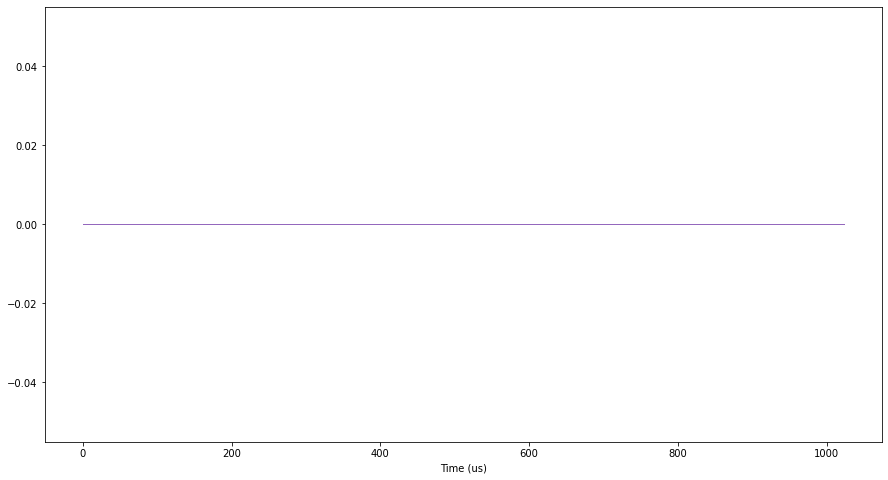

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,8)) #,dpi=300
# colors = np.array(['red','orange','blue'])
for bb in range(5):
    ax.plot(ACdata_test[5,0,bb,:,0], ls='-', lw=1)
ax.set_xlabel('Time (us)')
# ax.set_xlim([200, 400])
# ax.vlines([10,20], -Offset*(chnum+1), Offset*1, colors='k')
plt.show()

In [51]:
# which2drop = np.array([]);

for bb in range(WF_chunk+1):
    if np.sum(ACdata_test[aa,0,0,:,0]) == 0:
        np.delete(ACdata_test[bb,0,0,:,0],bb)

In [57]:
np.delete(ACdata_test,5,0).shape, ACdata_test.shape

((5, 8, 11, 1024, 512), (6, 8, 11, 1024, 512))

In [56]:
ACdata_test.shape

(6, 8, 11, 1024, 512)

In [159]:
# -----------------------------------------------------------------------------
# THIS SHOULD BE CONVERTED INTO A MODULE
# ANOTHER NOTE: WE CAN LOAD MORE THAN ONE WF_ FILE INTO MEMORY AT A TIME
# GENERAL IDEA: NUM_FILES = (0.75*AVAILABLE_MEM) / SIZE(WF_)
#               LOAD(NUM_FILES)... MOVE TO NEXT BLOCK OF FILES
# -----------------------------------------------------------------------------
for hh = 1:acN # from 1 to the total number of stacked waveforms
    
    fullWF = zeros(WFlength,numCHR,numCHT);    
    # stack WFs
    chnumt = 1; # transmitter index
    for kk = 1:NtoStack*numCHT  
        if (jj == 1) || (ii == filenumber1 && jj == idxWFwithinfile1) # open new file if jj = 1 or if it's the first file
            print('File number '+str(ii)+'.\n') # display file number            
            ACdata = LoadAcFile(WF_path,ii,numCHR,numSFpfile); 
        end
        fullWF(:,:,chnumt) = fullWF(:,:,chnumt) + ACdata(WFlength*(jj-1)+1:WFlength*jj,:); # read data
        if chnumt < numCHT # chnumt runs from 1 to numCHT
            chnumt = chnumt + 1;
        else
            chnumt = 1;
        end        
        
        if jj < numWFpfilepCH   # stay within the same file for the next run
            jj = jj + 1;
        else                    # use next file for the next run
            jj = 1;ii = ii + 1;

    fullWF = fullWF/NtoStack; # stacked WF      
    
#     if Filter == 'yes'
#         fullWF = filtfilt(filterparam,1,fullWF); # filtering
#         if Filter.view
#             figure(765);plot(fullWF(:,1,1));hold on; # plot pair R1-T1 unfiltered
#             plot(fullWF(:,1,1),'k');hold off; # plot pair R1-T1 filtered
    
    # WF is the part to be analyzed    
    WF = zeros(maxwindowlength,numCHR,numCHT);
    for chnumt = 1:numCHT
        for chnumr = 1:numCHR
            WF(1:windows_length(1,chnumr,chnumt),chnumr,chnumt) = fullWF(IdxWindow(1,chnumr,chnumt):IdxWindow(2,chnumr,chnumt),chnumr,chnumt); # part of the WF to be analyzed
           
    
    # cross-correlate (time delay)
    for chnumt = 1:numCHT
        for chnumr = 1:numCHR                        
            corr_signals = xcorr(WFref(:,chnumr,chnumt),WF(:,chnumr,chnumt),'coeff');
            [MaxInter(hh,chnumr,chnumt),TimeShift(hh,chnumr,chnumt)] = delay(corr_signals,ts);                                                                                        

    
    # amplitudes (time domain)
    RmsAmp(hh,:,:) = rms(WF,1);               # RmsAmp of the waveform
    Amp(hh,:,:) = max(WF,[],1)-min(WF,[],1);  # Max Amp of the waveform
    
    
    # aamplitudes (frequency domain)
    [freqQAmp(hh,:,:), maxAmp(hh,:,:), maxFreq(hh,:,:)] = AmplitudeFreq(sampFreq, WF, NZpad,freqQ);
   
#     This is unnecessary    
#     if hh/1000==round(hh/1000) # display Max intercorrelation every 100 stacked waveforms
#         MaxInterCorrelation = squeeze(MaxInter(hh,:,:));
#         display(MaxInterCorrelation)

#     figure(FigXcorr)
#     # display waveforms        
#     if (displayoptions == 0) || (displayoptions == 1 && (hh-1)/1000==round((hh-1)/1000))
#         idxoffset = 1;        
#         for chnumt = 1:numCHT
#             for chnumr = 1:numCHR                 
#                 h1(chnumr,chnumt) = plot(timeWF,fullWFref(:,chnumr,chnumt)-Offset*(idxoffset-1),'r');hold on                                
#                 h2(chnumr,chnumt) = plot(timeWF(IdxWindow(1,chnumr,chnumt):IdxWindow(2,chnumr,chnumt)),WFref(1:windows_length(1,chnumr,chnumt),chnumr,chnumt)-Offset*(idxoffset-1),'g'); #hold on;                
#                 h3(chnumr,chnumt) = plot(timeWF,fullWF(:,chnumr,chnumt)-Offset*(idxoffset-1),'b');
#                 h4(chnumr,chnumt) = plot(timeWF(IdxWindow(1,chnumr,chnumt):IdxWindow(2,chnumr,chnumt)),WF(1:windows_length(1,chnumr,chnumt),chnumr,chnumt)-Offset*(idxoffset-1),'k'); #hold on
#                 drawnow
#                 idxoffset = idxoffset + 1; #pause         
#             end
#         end
#         cla(gca); # clear former WFs without removing axis properties
#     end   

# FOR NOW, ONLY IMPLEMENT ABSREF
    # for chnumt = 1:numCHT
    #     for chnumr = 1:numCHR
    #         # choose reference WF for the next run when relref is used.
    #         if strcmp(reference.type,'relref') && MaxInter(hh,chnumr,chnumt) >= threshold                
    #             # current WF becomes reference WF for the next run if max
    #             # of intercorrelation is above threshold
    #             fullWFref(:,chnumr,chnumt) = fullWF(:,chnumr,chnumt);
    #             WFref(:,chnumr,chnumt) = WF(:,chnumr,chnumt);                
    #         elseif strcmp(reference.type,'relref') && MaxInter(hh,chnumr,chnumt) < threshold                
    #             # MaxInter is lower than threshold.
    #             # result of cross-correlation is replaced by NaN and we
    #             # don't keep the current WF as a reference for the next run
    #             TimeShift(hh,chnumr,chnumt) = NaN;
    #             RmsAmp(hh,chnumr,chnumt) = NaN;                

    #         # if mixref and last 5 waveforms have MaxInter below threshold 
    #         if hh >= 5 
    #             if strcmp(reference.type,'mixref') && sum(MaxInter(hh-4:hh,chnumr,chnumt) < threshold) == 5  # last 5 waveforms are below threshold
    #             if strcmp(reference,'mixref') && sum(MaxInter(hh,chnumr,chnumt) < threshold) == 1 # last waveform are below threshold
    #                 # current WF becomes reference WF for the next runs
    #                 fullWFref(:,chnumr,chnumt) = fullWF(:,chnumr,chnumt);
    #                 WFref(:,chnumr,chnumt) = WF(:,chnumr,chnumt);
                    
    #                 # keep track of when the ref has changed (use structure because the number of ref changes are not equal for all combinations of T-R)
    #                 chrefname = ['R' num2str(chnumr) 'T' num2str(chnumt)];
    #                 try
    #                     changeref.(chrefname) = [changeref.(chrefname) hh]; # keep track of when the ref has changed
    #                 catch
    #                     changeref.(chrefname) = hh;

# take the opposite such that a positive TimeShift means later arrival.
TimeShift = -TimeShift;

In [159]:


# sum up all time differences when 'relref' is used
if strcmp(reference.type,'relref')

    #THIS CAN BE IGNORED -- USE NP.NANCUMSUM
#     idxNaN = isnan(TimeShift); # find NaNs
#     TimeShift(idxNaN) = 0; # 0 instead of NaN to be able to use cumsum below
    
    # sum up all the delays and put back NaN into the final vector
    TimeShift = np.nancumsum(TimeShift)
#     TimeShift(idxNaN) = np.nan;
# adjust TimeShift based on when the reference has changed (mixref option)
if strcmp(reference.type,'mixref') && exist('changeref','var')
    for chnumt = 1:numCHT
        for chnumr = 1:numCHR
            chrefname = ['R' num2str(chnumr) 'T' num2str(chnumt)];                        
            if isfield(changeref,(chrefname)) # test if the ref was changed for this pair of T & R            
                kk = 1;
                for gh = changeref.(chrefname)
                    if gh == changeref.(chrefname)(end) # if last index, correct until the end
                        upbound = length(TimeShift(:,chnumr,chnumt));
                    else
                        upbound = changeref.(chrefname)(kk+1); # correct until next reference
                    end
                    TimeShift(gh+1:upbound,chnumr,chnumt) = TimeShift(gh+1:upbound,chnumr,chnumt) + TimeShift(gh,chnumr,chnumt);
                    kk = kk + 1;

(3,)

In [ ]:
# save data
# filename of the resulting mat file with explicit name based on chosen paramters
if strcmp(ref.type,'relref') || strcmp(ref.type,'mixref')
    refname = [ref.type '_Th' num2str(threshold)]; # add threshold value to the name when using relative or mixed reference
else
    refname = ref.type;
end

if ~isempty(TimeRange)
   filenamedata = ['Results_' runname '_' acousticrun '_' num2str(LocalAcTime(1,1)) 's-' num2str(LocalAcTime(end,end)) 's_Stack' num2str(NtoStack) 'WFs_' refname '_wAmp.mat'];
else
   filenamedata = ['Results_' runname '_' acousticrun '_fullrun_Stack' num2str(NtoStack) 'WFs_' refname '_wAmp.mat'];    
end
       
save(filenamedata,...
    'LocalAcTime','RmsAmp','Amp','AmpRef','MaxInter','TimeShift',...        
    'RmsAmpRef','fullWFref','idx2analyze','NtoStack','ref','threshold','Filter','TimeRange', 'freqQAmp', 'maxAmp', 'maxFreq','FreqQ','NZPad');
       
return